In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib

In [2]:
%matplotlib notebook

In [3]:
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))

numpy version: 1.15.4
pandas version: 0.23.4
matplotlib version: 3.0.1


# Figure 5

Create Figure 5 (the redshift residuals for SEDm in the ZTF BTS) in [Fremling et al. 2020](https://ui.adsabs.harvard.edu/abs/2019arXiv191012973F/abstract).

In [4]:
# BTS data
bts_df = pd.read_hdf('../data/final_rcf_table.h5')

In [5]:
z_sn = bts_df.z_sn.values
z_host = bts_df.z_host.values

norm_Ia = np.where( ( (bts_df.sn_type == 'Ia-norm') | 
                      (bts_df.sn_type == 'Ia') | 
                      (bts_df.sn_type == 'Ia-91bg') | 
                      (bts_df.sn_type == 'Ia-91T') | 
                      (bts_df.sn_type == 'Ia-99aa') | 
                      (bts_df.sn_type == 'ia')
                     | (bts_df.sn_type == 'Ia-norm*')
                     | (bts_df.sn_type == 'Ia-91T*')
                     | (bts_df.sn_type == 'Ia-91T**')
                     | (bts_df.sn_type == 'SN Ia')
                    )
                  )

norm_cc = np.where( (bts_df.sn_type == 'IIb') | 
                    (bts_df.sn_type == 'Ib') | 
                    (bts_df.sn_type == 'IIP') | 
                    (bts_df.sn_type == 'Ib/c') | 
                    (bts_df.sn_type == 'Ic-norm') | 
                    (bts_df.sn_type == 'IIn') | 
                    (bts_df.sn_type == 'IIL') | 
                    (bts_df.sn_type == 'Ic-broad') | 
                    (bts_df.sn_type == 'II') | 
                    (bts_df.sn_type == 'II-pec') | 
                    (bts_df.sn_type == 'Ib-pec') | 
                    (bts_df.sn_type == 'Ic') | 
                    (bts_df.sn_type == 'Ic-BL') | 
                    (bts_df.sn_type == 'IIP*') | 
                    (bts_df.sn_type == 'II*') | 
                    (bts_df.sn_type == 'Ibn') | 
                    (bts_df.sn_type == 'II**') | 
                    (bts_df.sn_type == 'Ib-norm') | 
                    (bts_df.sn_type == 'IIn*')
                  )

has_host_z = np.where((z_host > 0) & np.isfinite(z_host))
no_host = np.where((z_host < 0) | np.isnan(z_host))

has_host_cc = np.intersect1d(has_host_z, norm_cc)
has_host_ia = np.intersect1d(has_host_z, norm_Ia)

no_host_cc = np.intersect1d(no_host, norm_cc)
no_host_ia = np.intersect1d(no_host, norm_Ia)

z_mix = z_sn.copy()
z_mix[has_host_z] = z_host[has_host_z]

In [6]:
params = {'bandwidth': np.logspace(-4, -1, 40)}
grid_ia = GridSearchCV(KernelDensity(), params, cv=10)
ia_data = np.reshape(z_sn[has_host_ia]-z_host[has_host_ia], (len(has_host_ia), 1))
grid_ia.fit(ia_data)

grid_cc = GridSearchCV(KernelDensity(), params, cv=10)
cc_data = np.reshape(z_sn[has_host_cc]-z_host[has_host_cc], (len(has_host_cc), 1))
grid_cc.fit(cc_data)

print("best bandwidth: {0}".format(grid_ia.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde_ia = grid_ia.best_estimator_
kde_cc = grid_cc.best_estimator_

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best bandwidth: 0.002030917620904735


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [7]:
residuals_grid = np.linspace(-.03,0.04,500)
log_pdf_ia = kde_ia.score_samples(residuals_grid[:, np.newaxis])
log_pdf_cc = kde_cc.score_samples(residuals_grid[:, np.newaxis])

<IPython.core.display.Javascript object>


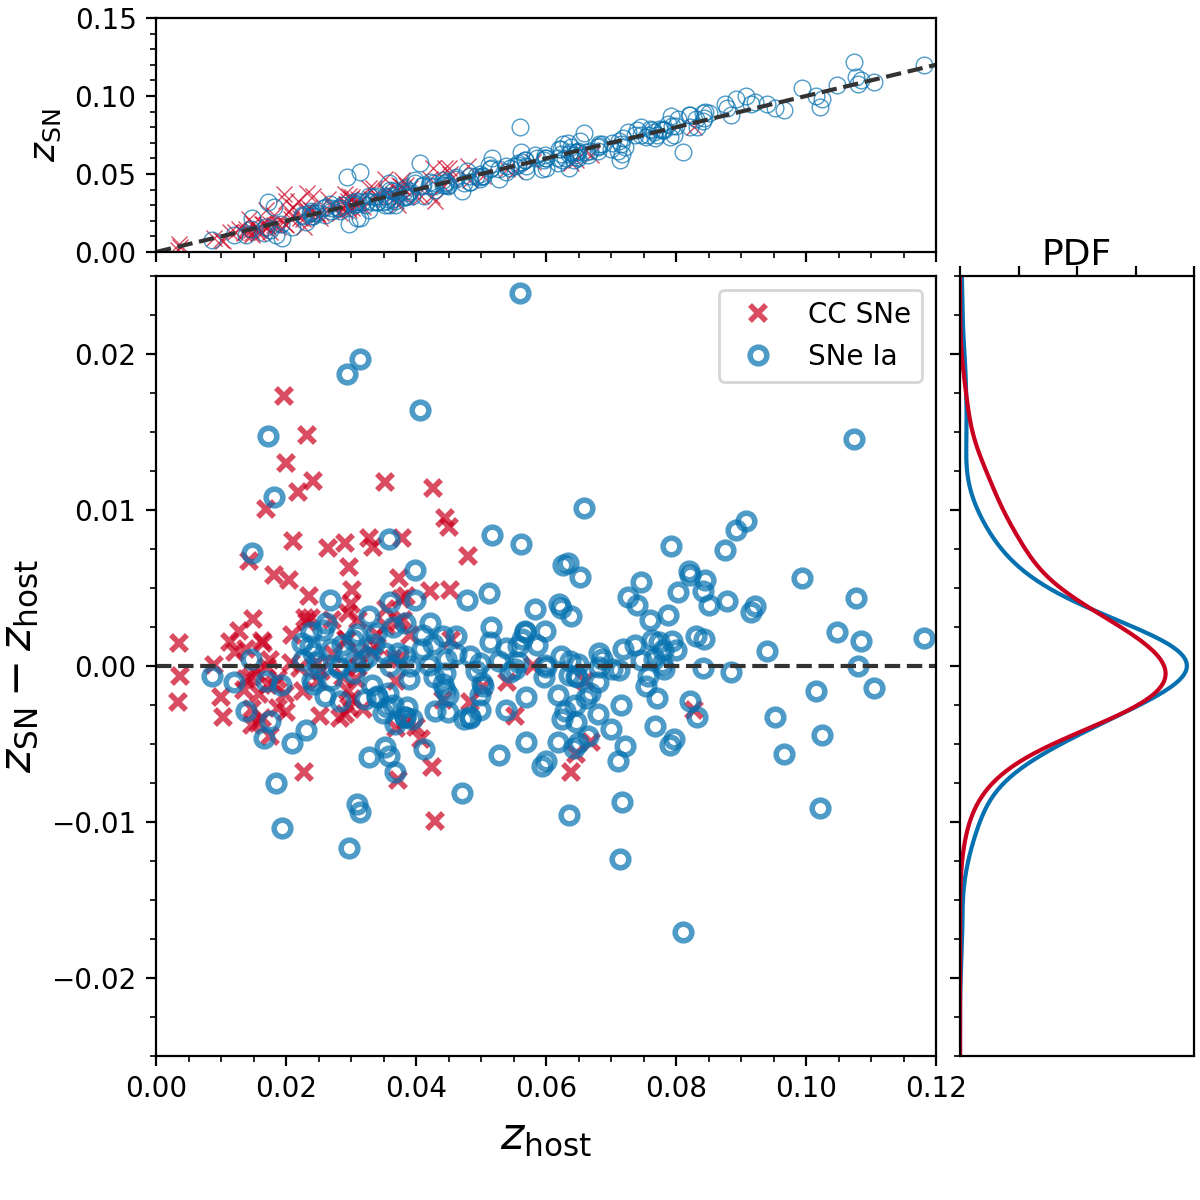

In [8]:
left, width = 0.13, 0.65
bottom, height = 0.12, 0.65
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.195]
rect_histy = [left_h, bottom, 0.195, height]

color_dict = {'Ia': '#0571b0', 
              'cc': '#ca0020'}

# start with a rectangular Figure
fig = plt.figure(figsize=(6, 6))

axResiduals = plt.axes(rect_scatter)
axLinear = plt.axes(rect_histx)
axHistRes = plt.axes(rect_histy)

axResiduals.plot(z_host[has_host_cc], z_sn[has_host_cc]-z_host[has_host_cc], 'x', 
        mec=color_dict['cc'], mew=2, alpha=0.7, label='CC SNe')
axResiduals.plot(z_host[has_host_ia], z_sn[has_host_ia]-z_host[has_host_ia], 'o', 
        mfc='None', mec=color_dict['Ia'], mew=2, alpha=0.7, label='SNe Ia')
axResiduals.plot([0,0.15], [0,0], '--', color='0.2')
axResiduals.set_xlim(0,0.12)
axResiduals.set_ylim(-0.025, 0.025)

axResiduals.set_ylabel(r"$z_\mathrm{SN} - z_\mathrm{host}$", fontsize = 16)
axResiduals.set_xlabel(r"$z_\mathrm{host}$", fontsize = 16)
axResiduals.legend(fancybox=True)
axResiduals.xaxis.set_minor_locator(MultipleLocator(0.005))
axResiduals.yaxis.set_minor_locator(MultipleLocator(0.0025))

axHistRes.plot(np.exp(log_pdf_ia), residuals_grid,
               color=color_dict['Ia'])
axHistRes.plot(np.exp(log_pdf_cc), residuals_grid,
               color=color_dict['cc'])
axHistRes.set_ylim(-0.025, 0.025)
axHistRes.set_xlim(0, 100)
axHistRes.set_yticklabels([])
axHistRes.tick_params(axis="x", which="both",
                    top=True, bottom=False,
                    labeltop=False, labelbottom=False,
                    labelrotation=270) 
axHistRes.set_xlabel(r"PDF", fontsize = 13)
axHistRes.xaxis.set_label_position('top')
axHistRes.xaxis.set_major_locator(MultipleLocator(25))
axHistRes.yaxis.set_minor_locator(MultipleLocator(0.0025))


axLinear.plot(z_host[has_host_cc], z_sn[has_host_cc], 'x', 
              mec=color_dict['cc'], mew=0.5, alpha=0.7)
axLinear.plot(z_host[has_host_ia], z_sn[has_host_ia], 'o', 
              mfc='None', mec=color_dict['Ia'], mew=0.5, alpha=0.7)
axLinear.plot([0,0.15], [0,0.15], '--', color='0.2')
axLinear.set_xlim(0,0.12)
axLinear.set_ylim(0,0.15)
axLinear.set_xticklabels([])
axLinear.set_ylabel(r"$z_\mathrm{SN}$", fontsize = 13)
axLinear.xaxis.set_minor_locator(MultipleLocator(0.005))
axLinear.yaxis.set_minor_locator(MultipleLocator(0.01))

fig.savefig('redshift_residuals.pdf')